Abaikan bagian **Data Gathering** jika sudah memiliki file datasetnya.

Upload datasetnya secara manual dan jalankan kode program dari bagian **Data Analysis** dan seterusnya.

# Data Gathering

Install library google-play-scrapper untuk melakukan scrapping reviews.

In [ ]:
!pip install google-play-scraper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.0 MB/s eta 0:00:00


Code dibawah ini untuk memperbaiki masalah limitasi scraping data di library google-play-scrapper, abaikan saja.

In [ ]:
import json
from time import sleep
from typing import List, Optional, Tuple

from google_play_scraper import Sort
from google_play_scraper.constants.element import ElementSpecs
from google_play_scraper.constants.regex import Regex
from google_play_scraper.constants.request import Formats
from google_play_scraper.utils.request import post

MAX_COUNT_EACH_FETCH = 199

class _ContinuationToken:
    __slots__ = (
        "token",
        "lang",
        "country",
        "sort",
        "count",
        "filter_score_with",
        "filter_device_with",
    )

    def __init__(self, token, lang, country, sort, count, filter_score_with, filter_device_with):
        self.token = token
        self.lang = lang
        self.country = country
        self.sort = sort
        self.count = count
        self.filter_score_with = filter_score_with
        self.filter_device_with = filter_device_with

def _fetch_review_items(
    url: str,
    app_id: str,
    sort: int,
    count: int,
    filter_score_with: Optional[int],
    filter_device_with: Optional[int],
    pagination_token: Optional[str],
):
    dom = post(
        url,
        Formats.Reviews.build_body(
            app_id,
            sort,
            count,
            "null" if filter_score_with is None else filter_score_with,
            "null" if filter_device_with is None else filter_device_with,
            pagination_token,
        ),
        {"content-type": "application/x-www-form-urlencoded"},
    )
    match = json.loads(Regex.REVIEWS.findall(dom)[0])

    return json.loads(match[0][2])[0], json.loads(match[0][2])[-2][-1]


def reviews(
    app_id: str,
    lang: str = "en",
    country: str = "us",
    sort: Sort = Sort.NEWEST,
    count: int = 100,
    filter_score_with: int = None,
    filter_device_with: int = None,
    continuation_token: _ContinuationToken = None,
) -> Tuple[List[dict], _ContinuationToken]:
    sort = sort.value

    if continuation_token is not None:
        token = continuation_token.token

        if token is None:
            return ([], continuation_token)

        lang = continuation_token.lang
        country = continuation_token.country
        sort = continuation_token.sort
        count = continuation_token.count
        filter_score_with = continuation_token.filter_score_with
        filter_device_with = continuation_token.filter_device_with
    else:
        token = None

    url = Formats.Reviews.build(lang=lang, country=country)
    _fetch_count = count

    result = []

    while True:
        if _fetch_count == 0:
            break

        if _fetch_count > MAX_COUNT_EACH_FETCH:
            _fetch_count = MAX_COUNT_EACH_FETCH

        try:
            review_items, token = _fetch_review_items(
                url,
                app_id,
                sort,
                _fetch_count,
                filter_score_with,
                filter_device_with,
                token,
            )
        except (TypeError, IndexError):
            #funnan MOD start
            token = continuation_token.token
            continue
            #MOD end

        for review in review_items:
            result.append({ k: spec.extract_content(review) for k, spec in ElementSpecs.Review.items() })

        _fetch_count = count - len(result)

        if isinstance(token, list):
            token = None
            break

    return (
        result,
        _ContinuationToken(token, lang, country, sort, count, filter_score_with, filter_device_with)
    )


def reviews_all(app_id: str, sleep_milliseconds: int = 0, **kwargs) -> list:
    kwargs.pop("count", None)
    kwargs.pop("continuation_token", None)

    continuation_token = None

    result = []

    while True:
        _result, continuation_token = reviews(
            app_id,
            count=MAX_COUNT_EACH_FETCH,
            continuation_token=continuation_token,
            **kwargs
        )

        result += _result

        if continuation_token.token is None:
            break

        if sleep_milliseconds:
            sleep(sleep_milliseconds / 1000)

    return result

Data gathering, scrape 10000 data and export it in csv format.

In [ ]:
import pandas as pd

# App id aplikasi thread
app_id = 'com.instagram.barcelona'

# Menyimpan data ulasan
all_reviews = []
continuation_token = None
reviews_count = 10000

while len(all_reviews) < reviews_count:
    new_result, continuation_token = reviews(
        app_id,
        continuation_token=continuation_token,
        lang='id',
        country='id',
        sort=Sort.NEWEST,
        filter_score_with=None,
        count=200
    )
    if not new_result:
        break
    all_reviews.extend(new_result)

# Membuat DataFrame dari ulasan
reviews_df = pd.DataFrame(all_reviews)
reviews_df.to_csv('threads_reviews_raw.csv', index=False, escapechar='\\')

print(f'Ulasan telah disimpan ke threads_reviews_raw.csv dengan {len(all_reviews)} ulasan.')

# Data Analysis

In [46]:
import pandas as pd
import os

# Memeriksa apakah berjalan di Google Colab
try:
    from google.colab import files
    colab = True
except ImportError:
    colab = False

In [47]:
# Hyperparameter
EPOCHS = 100
BATCH_SIZE = 32
RANDOM_SEED = 42

In [48]:
import random
import numpy as np
import tensorflow as tf

# Set random seed
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

Load data yang telah diexport dan tampilkan 5 data teratas untuk dianalisa.

In [49]:
# Mencoba membaca file CSV
file_path = 'threads_reviews_raw.csv'

try:
    df = pd.read_csv(file_path)
    print(f"File '{file_path}' berhasil dimuat.")
except FileNotFoundError:
    if colab:
        print(f"File '{file_path}' tidak ditemukan. Silakan unggah file.")
        uploaded = files.upload()
        file_path = list(uploaded.keys())[0]
        df = pd.read_csv(file_path)
        print(f"File '{file_path}' berhasil dimuat.")
    else:
        print(f"File '{file_path}' tidak ditemukan dan tidak berjalan di Google Colab. Silakan periksa jalur file.")

# Menampilkan 5 baris pertama dari dataframe
df.head()

File 'threads_reviews_raw.csv' berhasil dimuat.


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,7ea65f64-bd3b-4aff-93a1-39e8b36891cb,Mujib jibun2,https://play-lh.googleusercontent.com/a-/ALV-U...,sangat membantu tuk saling mengenal walaupun b...,3,1,NaN,2024-05-27 17:24:26,NaN,NaN,NaN
1,7265cb8a-4561-406a-8a5f-76706afe1781,Ali Alvaro,https://play-lh.googleusercontent.com/a-/ALV-U...,mantap,5,1,332.0.0.34.109,2024-05-27 16:28:29,NaN,NaN,332.0.0.34.109
2,dc50a966-03f2-4811-a8f0-8b163ca2f978,Pras Tian,https://play-lh.googleusercontent.com/a-/ALV-U...,Udah baru suruh perbarui lagi anjg,1,1,332.0.0.34.109,2024-05-27 15:52:27,NaN,NaN,332.0.0.34.109
3,f1447506-380b-4c38-bcfb-a8a1fabfab48,Heru Wahyudi,https://play-lh.googleusercontent.com/a-/ALV-U...,Bagus,5,0,NaN,2024-05-27 13:47:23,NaN,NaN,NaN
4,75923e39-7926-464e-a2ab-39101bd61acd,Jansen Tempomisa,https://play-lh.googleusercontent.com/a-/ALV-U...,aplikasinya mirip-mirip Instagram👍🏻,1,1,332.0.0.34.109,2024-05-27 13:36:23,NaN,NaN,332.0.0.34.109


In [50]:
df['at'] = pd.to_datetime(df['at'])

# Get tanggal paling awal dan paling akhir di kolom 'at'
min_date = df['at'].min()
max_date = df['at'].max()

# Menampilkan rentang tanggal ulasan
print(f"Rentang tanggal ulasan adalah dari {min_date} hingga {max_date}.")

Rentang tanggal ulasan adalah dari 2023-07-07 12:27:18 hingga 2024-05-27 17:24:26.


In [51]:
# Memeriksa jumlah nilai yang hilang (missing values) di setiap kolom
print("\nJumlah nilai yang hilang di setiap kolom:")
print(df.isnull().sum())


Jumlah nilai yang hilang di setiap kolom:
reviewId                    0
userName                    0
userImage                   0
content                     0
score                       0
thumbsUpCount               0
reviewCreatedVersion     3399
at                          0
replyContent            10000
repliedAt               10000
appVersion               3399
dtype: int64


In [52]:
# Memeriksa jumlah nilai duplikat
print("\nJumlah nilai duplikat:")
print(df['content'].duplicated().sum())


Jumlah nilai duplikat:
6489


# Data Pre-processing

Karena kita melakukan tugas Sentiment Analysis, maka kita hanya membutuhkan teks komentar pengguna dan score ratingnya. Dimana skor rating akan dipetakan kedalam 3 kategori yaitu, positif, netral, dan negatif.

In [53]:
# Menyimpan hanya kolom 'content' dan 'score'
df = df.loc[:, ['content', 'score']]
df.head()

,content,score
0,sangat membantu tuk saling mengenal walaupun b...,3
1,mantap,5
2,Udah baru suruh perbarui lagi anjg,1
3,Bagus,5
4,aplikasinya mirip-mirip Instagram👍🏻,1


In [54]:
# Install library emoji
!pip install emoji
!pip install sastrawi

In [55]:
import regex as re
import string
import emoji
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Download data NLTK yang dibutuhkan
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [56]:
# Inisialisasi objek stemmer untuk Bahasa Indonesia
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Definisikan stop words
stop_words = set(stopwords.words('indonesian'))

# Definisikan pola regex untuk mencocokkan karakter non-abjad dalam bahasa apa pun
non_alphabetic_pattern = re.compile(r'[^\p{L}\s]')

Tahapan pembersihan teks, dimulai dari lowercasing/case folding, maping emoji ke deskripsi teks, menghapus tanda baca angka whitespace, dan lainnya.

### 1. Mengubah Emoji

In [57]:
# Ubah emoji dengan deskripsi teksnya
df['content'] = df['content'].apply(lambda text: emoji.demojize(text, language='id'))
df.head()

# Menyimpan dataframe yang telah diproses ke file CSV baru
df.to_csv('threads_reviews_mengubah_emoji.csv', index=False)

### 2. Case Folding

In [58]:
# Ubah teks menjadi huruf kecil
df['content'] = df['content'].str.lower()
df.head()

# Menyimpan dataframe yang telah diproses ke file CSV baru
df.to_csv('threads_reviews_case_folding.csv', index=False)

### 3. Tokenisasi

In [59]:
# Tokenisasi
df['content'] = df['content'].apply(word_tokenize)
df.head()

# Menyimpan dataframe yang telah diproses ke file CSV baru
df.to_csv('threads_reviews_tokenisasi.csv', index=False)

### 4. Menghapus Stop Words

In [60]:
# Proses penghapusan stop words
df['content'] = df['content'].apply(lambda tokens: [word for word in tokens if word not in stop_words])
df.head()

# Menyimpan dataframe yang telah diproses ke file CSV baru
df.to_csv('threads_reviews_stop_words.csv', index=False)

### 5. Stemming

In [61]:
# Stemming dengan Sastrawi
df['content'] = df['content'].apply(lambda tokens: [stemmer.stem(word) for word in tokens])
df.head()

# Menyimpan dataframe yang telah diproses ke file CSV baru
df.to_csv('threads_reviews_stemming.csv', index=False)

### 6. Data Cleansing

In [62]:
# Gabungkan kembali token menjadi satu string
df['content'] = df['content'].apply(lambda tokens: ' '.join(tokens))
df.head()

,content,score
0,bantu tuk kenal beda agama,3
1,mantap,5
2,udah suruh baru anjg,1
3,bagus,5
4,aplikasi mirip instagram jempol ke atas warna...,1


In [63]:
# Hapus karakter non-abjad
df['content'] = df['content'].apply(lambda text: re.sub(non_alphabetic_pattern, ' ', text))

# Hapus tanda baca
df['content'] = df['content'].apply(lambda text: text.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation))))

# Hapus angka
df['content'] = df['content'].apply(lambda text: re.sub(r'\d+', ' ', text))

# Hapus whitespace tambahan
df['content'] = df['content'].str.strip()

df.head()

,content,score
0,bantu tuk kenal beda agama,3
1,mantap,5
2,udah suruh baru anjg,1
3,bagus,5
4,aplikasi mirip instagram jempol ke atas warna...,1


In [64]:
# Menghapus nilai kosong dan string kosong
initial_len = len(df)
df.dropna(subset=['content'], inplace=True)
df = df[df['content'] != '']  # Menghapus baris di mana 'content' adalah string kosong
empty_values_removed = initial_len - len(df)
print(f"\nJumlah nilai kosong dan string kosong yang dihapus: {empty_values_removed}")


Jumlah nilai kosong dan string kosong yang dihapus: 164


In [65]:
# Menghapus nilai duplikat
initial_len = len(df)
df.drop_duplicates(subset=['content'], inplace=True)
duplicates_removed = initial_len - len(df)
print(f"\nJumlah nilai duplikat yang dihapus: {duplicates_removed}")


Jumlah nilai duplikat yang dihapus: 6618


<ipython-input-65-4d393ebad84e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset=['content'], inplace=True)


In [66]:
# Menyimpan dataframe yang telah diproses ke file CSV baru
df.to_csv('threads_reviews_data_cleansing.csv', index=False)

# Labeling Data

Labeling data, mapping rating ke label.

In [67]:
# Memetakan skor ke label
def map_to_label(score):
    if score <= 2:
        return 0  # Negatif
    elif score >= 4:
        return 1  # Positif
    else:
        return 2  # Netral

df['label'] = df['score'].apply(map_to_label)

In [68]:
# Mengabaikan kolom score, karena hanya kolom label yang digunakan untuk pelatihan model
df = df.loc[:, ['content', 'label']]

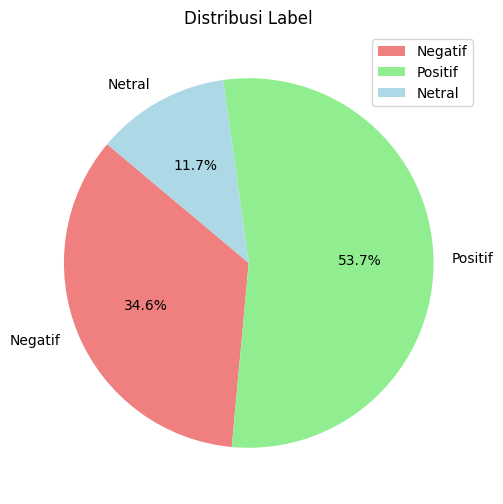

In [69]:
import matplotlib.pyplot as plt

# Mendefinisikan warna dan label untuk plot
colors = ['lightcoral', 'lightgreen', 'lightblue']
labels = ['Negatif', 'Positif', 'Netral']

# Membuat plot pie chart
plt.figure(figsize=(8, 6))
df['label'].value_counts().sort_index().plot(kind='pie', labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
plt.title('Distribusi Label')
plt.ylabel('')  # Menyembunyikan y-label karena tidak diperlukan pada pie chart
plt.legend(labels, loc="upper right")
plt.show()

In [70]:
label_counts = df['label'].value_counts().sort_index()
for label, count in label_counts.items():
    print(f'Label {label}: {count} reviews')

Label 0: 1115 reviews
Label 1: 1727 reviews
Label 2: 376 reviews


In [71]:
# Tampilkan 5 baris pertama dari dataframe yang telah diproses
df.head()

,content,label
0,bantu tuk kenal beda agama,2
1,mantap,1
2,udah suruh baru anjg,0
3,bagus,1
4,aplikasi mirip instagram jempol ke atas warna...,0


In [72]:
# Menyimpan dataframe yang telah diproses ke file CSV baru
df.to_csv('threads_reviews_preprocessed.csv', index=False)

print(f"\nDataframe yang telah diproses telah disimpan ke threads_reviews_preprocessed.csv dengan {len(df)} baris.")


Dataframe yang telah diproses telah disimpan ke threads_reviews_preprocessed.csv dengan 3218 baris.


Pembagian dataset menjadi tiga bagian: set pelatihan, set validasi, dan set pengujian menggunakan fungsi `train_test_split` dari `sklearn.model_selection`.

Proporsi pembagian data sebesar, 80% set pelatihan, 10% set validasi, dan 10% set pengujian.

In [73]:
from sklearn.model_selection import train_test_split

# Tentukan persentase pembagian
train_percent = 0.8
test_val_percent = 0.1  # 10% untuk data uji dan validasi masing-masing

# Membagi data menjadi set pelatihan, validasi, dan pengujian
train_val_df, test_df = train_test_split(df, test_size=test_val_percent, random_state=RANDOM_SEED)
train_df, val_df = train_test_split(train_val_df, test_size=test_val_percent/(1-test_val_percent), random_state=RANDOM_SEED)

# Cetak panjang set pelatihan, validasi, dan pengujian
print("Panjang set pelatihan:", len(train_df))
print("Panjang set validasi:", len(val_df))
print("Panjang set pengujian:", len(test_df))

Panjang set pelatihan: 2574
Panjang set validasi: 322
Panjang set pengujian: 322


# Training Data

In [74]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

# Tokenisasi data teks
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(train_df['content'])

# Konversi data teks menjadi urutan angka (sequences)
train_sequences = tokenizer.texts_to_sequences(train_df['content'])
val_sequences = tokenizer.texts_to_sequences(val_df['content'])
test_sequences = tokenizer.texts_to_sequences(test_df['content'])

# Print hasil dari tokenisasi
print("Hasil dari tokenisasi:")
print(train_df['content'][:1])
print(train_sequences[:1])

Hasil dari tokenisasi:
1721    kasih bintang
Name: content, dtype: object
[[29, 16]]


In [75]:
# Temukan urutan dengan panjang maksimum
max_length = max(len(seq.split()) for seq in train_df['content'])
sequence_with_max_length = train_df[train_df['content'].apply(lambda x: len(x.split())) == max_length]['content'].iloc[0]

# Cetak teks dengan panjang maksimum
print(f"Teks dengan panjang maksimum ({max_length} kata):")
print(sequence_with_max_length)

Teks dengan panjang maksimum (122 kata):
baguss bangetttttt  wajah dengan mata bentuk bintang  wajah dengan mata bentuk bintang  wajah dengan mata bentuk bintang  wajah dengan mata bentuk bintang  wajah dengan mata bentuk bintang  wajah dengan mata bentuk bintang  wajah dengan mata bentuk bintang  wajah dengan mata bentuk bintang  wajah dengan mata bentuk bintang  wajah dengan mata bentuk bintang  wajah dengan mata bentuk bintang  wajah dengan mata bentuk bintang  wajah dengan mata bentuk bintang  wajah dengan mata bentuk bintang  wajah dengan mata bentuk bintang  wajah dengan mata bentuk bintang  wajah dengan mata bentuk bintang  wajah dengan mata bentuk bintang  wajah dengan mata bentuk bintang  wajah dengan mata bentuk bintang  wajah dengan mata bentuk bintang  wajah dengan mata bentuk bintang  wajah dengan mata bentuk bintang  wajah dengan mata bentuk bintang


In [76]:
# Padding urutan agar memiliki panjang yang sama
train_data = pad_sequences(train_sequences, maxlen=max_length, padding='post')
val_data = pad_sequences(val_sequences, maxlen=max_length, padding='post')
test_data = pad_sequences(test_sequences, maxlen=max_length, padding='post')

# Print hasil dari pad_sequences
print("\nHasil dari pad_sequences:")
print(train_data[:1])  # Print baris pertama


Hasil dari pad_sequences:
[[29 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]]


## Training model dengan arsitektur Simple RNN

In [77]:
from tensorflow.keras.layers import SimpleRNN, Embedding, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

# Inisialisasi early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Definisikan model dengan SimpleRNN
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_length),
    SimpleRNN(128, return_sequences=True, kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    SimpleRNN(64, kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

# Kompilasi model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Latih model dengan data validasi dan early stopping
history = model.fit(train_data, train_df['label'], epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(val_data, val_df['label']), callbacks=[early_stopping])

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


81/81 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step - accuracy: 0.4648 - loss: 1.2950 - val_accuracy: 0.5435 - val_loss: 1.2075
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.4924 - loss: 1.2139 - val_accuracy: 0.5435 - val_loss: 1.1668
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.4868 - loss: 1.1867 - val_accuracy: 0.5435 - val_loss: 1.1601
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.4961 - loss: 1.1742 - val_accuracy: 0.5435 - val_loss: 1.1459
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.4978 - loss: 1.1425 - val_accuracy: 0.5435 - val_loss: 1.1294
Epoch 6/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5144 - loss: 1.1288 - val_accuracy: 0.5435 - val_loss: 1.1148
Epoch 7/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5120 - loss: 1.1184 - val_accuracy: 0.5435 - val_loss: 1.1032
Epoch 8/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.5134 - loss: 1.1008 - val_accuracy: 0.5435 - val_

## Training model dengan arsitektur Bidirectional LSTM

In [78]:
# from tensorflow.keras.layers import LSTM, Bidirectional
# from tensorflow.keras import regularizers
# from tensorflow.keras.callbacks import EarlyStopping

# # Inisialisasi early stopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# # Definisikan model LSTM
# model = Sequential([
#     Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_length),
#     Bidirectional(LSTM(256, return_sequences=True)),
#     Dropout(0.5),
#     Bidirectional(LSTM(128, return_sequences=True)),
#     Dropout(0.5),
#     Bidirectional(LSTM(64)),
#     Dropout(0.5),
#     Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
#     Dropout(0.5),
#     Dense(3, activation='softmax')
# ])

# # Kompilasi model
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # Latih model dengan data validasi dan early stopping
# history = model.fit(train_data, train_df['label'],
#                     epochs=EPOCHS, batch_size=BATCH_SIZE,
#                     validation_data=(val_data, val_df['label']),
#                     callbacks=[early_stopping])

# Model Evaluation

In [79]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

In [80]:
predictions = model.predict(test_data)
predicted_labels = np.argmax(predictions, axis=1)
predicted_labels

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

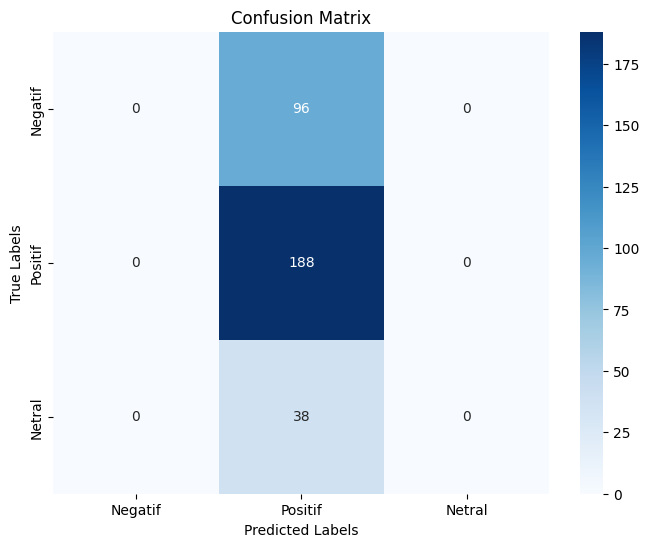

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

# Menghitung confusion matrix
conf_matrix = confusion_matrix(test_df['label'], predicted_labels)

# Membuat plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Positif', 'Netral'], yticklabels=['Negatif', 'Positif', 'Netral'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [82]:
# Hitung akurasi pada data uji, presisi, recall, dan skor F1
test_accuracy = accuracy_score(test_df['label'], predicted_labels)
precision = precision_score(test_df['label'], predicted_labels, average='weighted')
recall = recall_score(test_df['label'], predicted_labels, average='weighted')
f1 = f1_score(test_df['label'], predicted_labels, average='weighted')

print("Akurasi Uji:", test_accuracy)
print("Presisi:", precision)
print("Recall:", recall)
print("Skor F1:", f1)

Akurasi Uji: 0.5838509316770186
Presisi: 0.34088191042012267
Recall: 0.5838509316770186
Skor F1: 0.430446961393253


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
